In [33]:
using DrWatson
@quickactivate("Hierarchical_Infer_Spikes")

using Turing, CSV, StatsPlots, DataFrames, Distributions, Random, LinearAlgebra

# read in the data table
data = CSV.File(datadir("exp_raw","spikes_in_zones.csv"),header=1)|> DataFrame
data[!,"zones"] = [findfirst(isequal(d),["other","delay","choice","reward3","reward4"]) for d in data.zones]
data[data[!,"zones"].==5,"zones"] .= 4 
data[!,"animal"] = [findfirst(isequal(d),[2443,2453,2454,2462,2467,2486,149]) for d in data.animal]
data = data |> Matrix;

# append a new column to the data matrix that is the spike rate
data = hcat(data, data[:,4]./data[:,5])

175×6 Matrix{Float64}:
 7.0  1.0  3.0   3.0  59.7      0.0502513
 7.0  2.0  3.0   9.0  79.1333   0.113732
 7.0  3.0  3.0  23.0  77.7667   0.295757
 7.0  4.0  3.0  13.0  53.0      0.245283
 7.0  5.0  3.0  13.0  51.8667   0.250643
 1.0  1.0  3.0  27.0  73.9      0.365359
 1.0  2.0  3.0   0.0  36.3      0.0
 1.0  3.0  3.0   0.0  25.3      0.0
 1.0  4.0  3.0   0.0  30.2333   0.0
 1.0  5.0  3.0   0.0  35.6      0.0
 ⋮                              ⋮
 4.0  2.0  4.0   1.0   9.36667  0.106762
 4.0  3.0  4.0   4.0  20.5      0.195122
 4.0  4.0  4.0   6.0  33.9667   0.176644
 4.0  5.0  4.0   1.0  27.9333   0.0357995
 6.0  1.0  4.0  91.0  50.3667   1.80675
 6.0  2.0  4.0  21.0  80.9      0.25958
 6.0  3.0  4.0  30.0  47.4      0.632911
 6.0  4.0  4.0  39.0  84.9667   0.459004
 6.0  5.0  4.0  25.0  38.9667   0.641574

In [67]:
function hierarchial_bootstrap_zones(data, N_boot = 1000)
    zone_means = zeros(N_boot,4)
    for i in 1:N_boot
        # first sample with replacement animals
        animals = sample(1:7,7,replace=true)
        # then sample with replacement days
        days = sample(1:5,5,replace=true)

        # now calculate the mean rate for each zone for the sampled animals and days
        for z in 1:4
            zone_data = data[(data[:,1].==animals[1]) .& (data[:,2].==days[1]) .& (data[:,3].==z),6]
            for a in animals[2:end]
                for d in days[2:end]
                    # compute zone rate (spikes per second) for each animal and day
                    zone_data = vcat(zone_data,data[(data[:,1].==a) .& (data[:,2].==d) .& (data[:,3].==z),6])
                end
            end
            zone_means[i,z] = mean(zone_data)
        end
    end
    return zone_means
end

spike_rate_in_zones = hierarchial_bootstrap_zones(data,1000)

1000×4 Matrix{Float64}:
 0.487407  0.280031  0.317954  0.642399
 0.362763  0.219065  0.303187  0.247299
 1.28293   0.502748  0.813464  0.961133
 0.426447  0.31802   0.33743   0.835421
 0.506177  0.416482  0.398606  0.703455
 0.270465  0.314464  0.39404   0.27252
 0.856419  0.862272  0.967792  0.791186
 0.147141  0.216978  0.144624  0.317969
 0.37811   0.384114  0.345345  0.499043
 0.60761   0.113117  0.129447  1.68012
 ⋮                             
 0.853258  0.282778  0.741423  0.629813
 0.714824  0.594777  0.57244   0.718212
 0.486741  0.350809  0.37899   0.71582
 0.450916  0.430843  0.503797  0.606626
 0.230775  0.170418  0.178784  0.738315
 0.605212  0.135795  0.198147  0.950477
 0.705715  0.4797    0.617746  0.481879
 0.573783  0.559594  0.585564  0.488694
 0.587708  0.575501  0.558109  0.552947

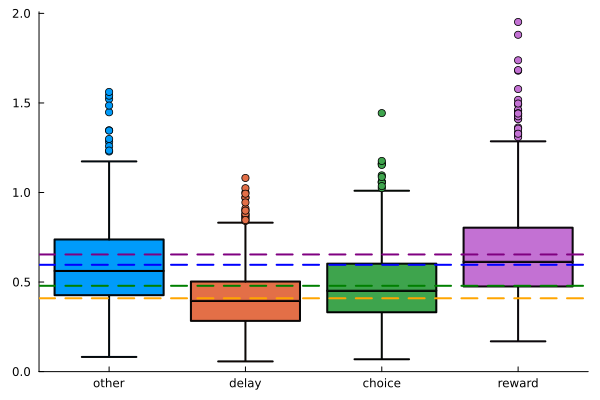

In [73]:
@df DataFrame(spike_rate_in_zones,:auto) boxplot([:x1,:x2,:x3,:x4],legend=false,grid=false,linewidth=2)
# plot mean from data in each zone
hline!([mean(data[data[:,3].==1,6])],color=:blue,linewidth=2,linestyle=:dash,label="data")
hline!([mean(data[data[:,3].==2,6])],color=:orange,linewidth=2,linestyle=:dash)
hline!([mean(data[data[:,3].==3,6])],color=:green,linewidth=2,linestyle=:dash)
hline!([mean(data[data[:,3].==4,6])],color=:purple,linewidth=2,linestyle=:dash)
xticks!(1:4,["other","delay","choice","reward"])

In [61]:
using HypothesisTests

OneWayANOVATest(spike_rate_in_zones[:,1],spike_rate_in_zones[:,2],spike_rate_in_zones[:,3],spike_rate_in_zones[:,4])

One-way analysis of variance (ANOVA) test
-----------------------------------------
Population details:
    parameter of interest:   Means
    value under h_0:         "all equal"
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    p-value:                     <1e-99

Details:
    number of observations: [1000, 1000, 1000, 1000]
    F statistic:            254.044
    degrees of freedom:     (3, 3996)


In [62]:
# now we can do a post-hoc test to see which zones are different
p_values = zeros(4,4)
for i in 1:4
    for j in 1:4
        if i != j
            p_values[i,j] = pvalue(UnequalVarianceTTest(spike_rate_in_zones[:,i],spike_rate_in_zones[:,j]))
        end
    end
end

p_values

4×4 Matrix{Float64}:
 0.0          3.18849e-87  4.002e-31    2.78956e-6
 3.18849e-87  0.0          4.39781e-19  6.8004e-118
 4.002e-31    4.39781e-19  0.0          2.9112e-55
 2.78956e-6   6.8004e-118  2.9112e-55   0.0